In [1]:
%matplotlib widget
import os, sys
import matplotlib
import matplotlib.pyplot as plt
print(os.getpid())

15780


In [2]:
sys.path.append(r'../..')
from ChromAn import src
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [3]:
image_folder = r'E:\Data\20240109-IF_F170\EpCAM488_ErpCAM568\Tests'
#image_folder = r'E:\Data\20231004-4T1tumor_F170section3_0927MF2-mCherry\H2M3'
image_basenames = sorted([_fl for _fl in os.listdir(image_folder) if _fl.split(os.extsep)[-1] =='dax'])
print(image_folder)
if len(image_basenames) < 20:
    print(image_basenames)
else:
    print(image_basenames[-20:])

E:\Data\20240116-waferImaging_DNAFISH\O6_PB30_TSFAM_NewSeq
['zscan_748_637_545_477_405_s30_n500_10Hz_0001.dax']


In [4]:
image_filename = os.path.join(image_folder, image_basenames[-1]) #select fov here
print(image_filename)
# load image
daxp = DaxProcesser(image_filename,
                    CorrectionFolder=r'\\everest\weissman_imaging\puzheng\Corrections\20230902-Merscope01_s30_n500', # Merscope01
                    #CorrectionFolder=r'\\wi-bigdata\weissman_imaging\puzheng\Corrections\20210621-STORM6_lumencor', # Storm6
                    #Channels=['748', '637', '545', '477', '405'],
                   )
daxp._load_image()
# corrections
#daxp._corr_bleedthrough()
daxp._corr_illumination()
#daxp._corr_hot_pixels()

E:\Data\20240116-waferImaging_DNAFISH\O6_PB30_TSFAM_NewSeq\zscan_748_637_545_477_405_s30_n500_10Hz_0001.dax
Initialize DaxProcesser for file:E:\Data\20240116-waferImaging_DNAFISH\O6_PB30_TSFAM_NewSeq\zscan_748_637_545_477_405_s30_n500_10Hz_0001.dax
- New save file: E:\Data\20240116-waferImaging_DNAFISH\O6_PB30_TSFAM_NewSeq\zscan_748_637_545_477_405_s30_n500_10Hz_0001_processed.hdf5
-- all used channels: ['748', '637', '545', '477', '405']
-- single image size: [  30 2304 2304]
- Loaded images for channels:['748', '637', '545', '477', '405'] in 0.926s.
- Correct illumination for channels: ['748', '637', '545', '477', '405']
-- Keep channels: ['748', '637', '545', '477', '405'] for corr_illumination.
- Start illumination correction for channels:['748', '637', '545', '477', '405'].
-- loading illumination correction profile from file:
	 748 illumination_correction_748_2304x2304.npy
	 637 illumination_correction_637_2304x2304.npy
	 545 illumination_correction_545_2304x2304.npy
	 477 illumi

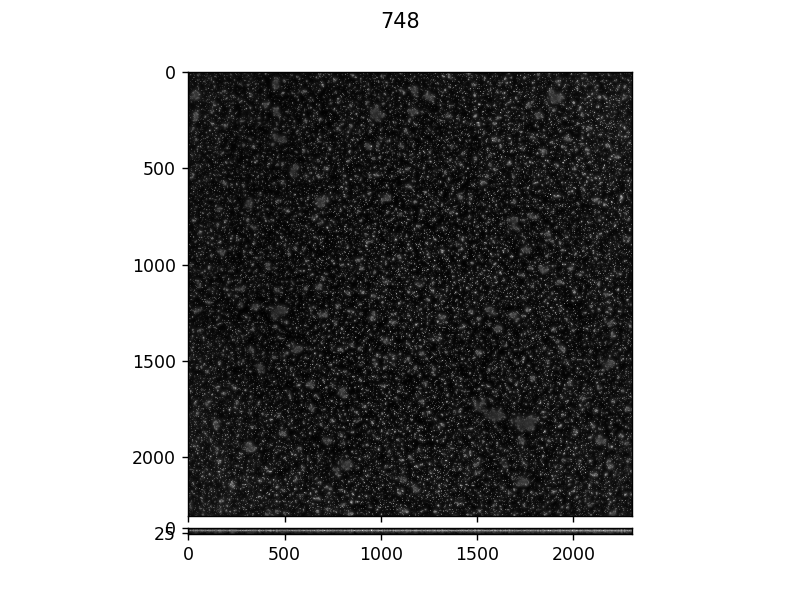

In [5]:
%matplotlib widget
f = plt.figure(dpi=125)
imshow_mark_3d([getattr(daxp, f"im_{_ch}") for _ch in daxp.channels][:], 
                fig=f,
                image_names=daxp.channels, 
                min_max_default=[100,10000],
                )


# Test-run segmentation

In [8]:
# Cellpose 
from cellpose import models
import time
import torch
import numpy as np

In [9]:
sys.path.append(r'C:/Softwares/Github/MerScope01/MERlin')
from merlin.analysis.segment import CellPoseSegment

Unable to find MERlin environment file at C:\Users\Weissman_Lab\.merlinenv. Please run 'merlin --configure .' in order to configure the environment.


In [15]:
# Create cellpose model
print(f"- run Cellpose segmentation", end=' ')
_cellpose_start = time.time()
torch.cuda.empty_cache() # empty cache to create new model
seg_model = models.CellposeModel(gpu=True, model_type='tissuenet')
                                 #model_type='CP_20231024_ingel_v4')
# Run cellpose prediction
labels3d, _, _ = seg_model.eval(np.stack([daxp.im_545, daxp.im_405], axis=3), 
                                batch_size=30, 
                                anisotropy=500/107,
                                cellprob_threshold=0, 
                                channels=[1,2], 
                                diameter=45, 
                                min_size=4000,
                                do_3D=False,
                                )
print(f"in {time.time()-_cellpose_start:.3f}s.")

- run Cellpose segmentation in 172.911s.


In [12]:
from typing import List, Dict, Tuple
def get_overlapping_objects(segmentationZ0: np.ndarray,
                            segmentationZ1: np.ndarray,
                            n0: int,
                            fraction_threshold0: float=0.2,
                            fraction_threshold1: float=0.2) -> Tuple[np.float64, 
                                              np.float64, np.float64]:
    """compare cell labels in adjacent image masks
    Args:
        segmentationZ0: a 2 dimensional numpy array containing a
            segmentation mask in position Z
        segmentationZ1: a 2 dimensional numpy array containing a
            segmentation mask adjacent to segmentationZ0
        n0: an integer with the index of the object (cell/nuclei)
            to be compared between the provided segmentation masks
    Returns:
        a tuple (n1, f0, f1) containing the label of the cell in Z1
        overlapping n0 (n1), the fraction of n0 overlaping n1 (f0) and
        the fraction of n1 overlapping n0 (f1)
    """

    z1Indexes = np.unique(segmentationZ1[segmentationZ0 == n0])

    z1Indexes = z1Indexes[z1Indexes > 0]

    if z1Indexes.shape[0] > 0:

        # calculate overlap fraction
        n0Area = np.count_nonzero(segmentationZ0 == n0)
        n1Area = np.zeros(len(z1Indexes))
        overlapArea = np.zeros(len(z1Indexes))

        for ii in range(len(z1Indexes)):
            n1 = z1Indexes[ii]
            n1Area[ii] = np.count_nonzero(segmentationZ1 == n1)
            overlapArea[ii] = np.count_nonzero((segmentationZ0 == n0) *
                                               (segmentationZ1 == n1))

        n0OverlapFraction = np.asarray(overlapArea / n0Area)
        n1OverlapFraction = np.asarray(overlapArea / n1Area)
        index = list(range(len(n0OverlapFraction)))

        # select the nuclei that has the highest fraction in n0 and n1
        r1, r2, indexSorted = zip(*sorted(zip(n0OverlapFraction,
                                              n1OverlapFraction,
                                              index),
                                  key=lambda x:x[0]+x[1],
                                  reverse=True))

        if (n0OverlapFraction[indexSorted[0]] > fraction_threshold0 and
                n1OverlapFraction[indexSorted[0]] > fraction_threshold1):
            return (z1Indexes[indexSorted[0]],
                    n0OverlapFraction[indexSorted[0]],
                    n1OverlapFraction[indexSorted[0]])
        else:
            return (False, False, False)
    else:
        return (False, False, False)

def combine_2d_segmentation_masks_into_3d(segmentationOutput: np.ndarray,
                                          minKept_zLen:int=2,
                                          matching_overlapRatio:float=0.33,
                                          ) -> np.ndarray:
    """Take a 3 dimensional segmentation masks and relabel them so that
    nuclei in adjacent sections have the same label if the area their
    overlap surpases certain threshold
    Args:
        segmentationOutput: a 3 dimensional numpy array containing the
            segmentation masks arranged as (z, x, y).
        minKept_zLen: minimum z-length of kept segmentation masks
        matching_overlapRatio: miminum overlap ratio bewteen two segmentation masks to be merged.
    Returns:
        ndarray containing a 3 dimensional mask arranged as (z, x, y) of
            relabeled segmented cells
    Upate:20240109
    """

    # Initialize empty array with size as segmentationOutput array
    segmentationCombinedZ = np.zeros(segmentationOutput.shape, dtype=segmentationOutput.dtype)

    # copy the mask of the section farthest to the coverslip to start
    segmentationCombinedZ[-1, :, :] = segmentationOutput[-1, :, :]
    
    # Edit by Pu Zheng: start the seed at the middle z-plane, because usually that is the focal plane:
    mid_z = int(segmentationCombinedZ.shape[0]/2)
    # get the mid plane:
    # copy the mask of the section farthest to the coverslip to start
    segmentationCombinedZ[mid_z, :, :] = segmentationOutput[mid_z, :, :]
    zs = np.arange(0, segmentationCombinedZ.shape[0])
    zs_2_ref = np.abs(zs - (mid_z- 0.01)) # a trick to make mid-z closest to ref
    zs_sorted = zs[np.argsort(zs_2_ref)]
    processed_zs = [mid_z]
    for _iz, _z in enumerate(zs_sorted):
        if _iz == 0:
            continue
        # get ref_z
        _ref_z = processed_zs[np.argmin(np.abs(np.array(processed_zs)-_z))]#zs_sorted[_iz - 1]
        #
        # get non-background cell indexes for plane Z
        zIndex = np.unique(segmentationOutput[_z, :, :])[
                           np.unique(segmentationOutput[_z, :, :]) > 0]
        # attach _z to _ref_z
        # get non-background cell indexes for plane Z-1
        refzIndex = np.unique(segmentationCombinedZ[_ref_z, :, :])[
                              np.unique(segmentationCombinedZ[_ref_z, :, :]) > 0]
        # record assigned index
        assigned_refzIndex = []
        print(_z, _ref_z)
        print(len(zIndex))
        # compare each cell in z0
        for n0 in refzIndex:
            n1, f0, f1 = get_overlapping_objects(segmentationCombinedZ[_ref_z, :, :],
                                                 segmentationOutput[_z, :, :],
                                                 n0, 
                                                 fraction_threshold0=matching_overlapRatio,
                                                 fraction_threshold1=matching_overlapRatio,)
            # If matched: merge
            if n1:
                segmentationCombinedZ[_z, :, :][
                    (segmentationOutput[_z, :, :] == n1)] = n0
                assigned_refzIndex.append(n1)
            # If not matched: copy next layer
            else:
                segmentationCombinedZ[_z, :, :][
                    (segmentationCombinedZ[_ref_z, :, :] == n0)] = n0
                #assigned_refzIndex.append(n1)
                
        # keep the un-assigned indices in the Z-1 plane
        unassigned_refzIndex = [i for i in refzIndex if i not in assigned_refzIndex]
        max_current_id = np.max(segmentationCombinedZ[_z:, :, :])
        for i in range(len(unassigned_refzIndex)):
            unassigned_id = unassigned_refzIndex[i]
            segmentationCombinedZ[_z, :, :][
                    (segmentationOutput[_z, :, :] == unassigned_id)] = max_current_id + 1 +i
        
        processed_zs.append(_z)
        print(processed_zs)
        
    # remove label with only 1 z-layer
    segmentationCleanedZ = np.zeros(segmentationOutput.shape, dtype=np.int16)
    for _lb in np.arange(1, np.max(segmentationCombinedZ)+1):
        _cellMask = (segmentationCombinedZ==_lb)
        _cell_zIndex = np.where(_cellMask.any((1,2)))[0]
        #print(_cell_zIndex)
        if len(_cell_zIndex) < minKept_zLen:
            continue
        else:
            segmentationCleanedZ[segmentationCombinedZ==_lb] = np.max(segmentationCleanedZ) + 1
                
            
            
    return segmentationCleanedZ

In [17]:
combined_labels3d = combine_2d_segmentation_masks_into_3d(labels3d)

19 20
239
[20, 19]
21 20
241
[20, 19, 21]
18 19
234
[20, 19, 21, 18]
22 21
243
[20, 19, 21, 18, 22]
17 18
235
[20, 19, 21, 18, 22, 17]
23 22
245
[20, 19, 21, 18, 22, 17, 23]
16 17
238
[20, 19, 21, 18, 22, 17, 23, 16]
24 23
236
[20, 19, 21, 18, 22, 17, 23, 16, 24]
15 16
233
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15]
25 24
235
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25]
14 15
229
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14]
26 25
228
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26]
13 14
230
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13]
27 26
215
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13, 27]
12 13
229
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13, 27, 12]
28 27
204
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13, 27, 12, 28]
11 12
226
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13, 27, 12, 28, 11]
29 28
191
[20, 19, 21, 18, 22, 17, 23, 16, 24, 15, 25, 14, 26, 13, 27, 12, 28, 11, 29]
10 11
233
[20, 19, 21, 18, 22, 17, 23, 16, 24,

In [18]:
np.max(labels3d)

245

## Visualize

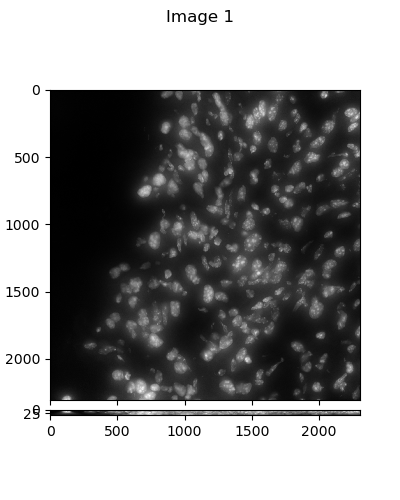

In [16]:
imshow_mark_3d([daxp.im_405, labels3d, combined_labels3d])

# Save layers for training

In [ ]:
# only show one layer:
sel_layer_id = 20
sel_layer = daxp.im_405[sel_layer_id]
plt.figure()
plt.imshow(sel_layer, vmin=2000, vmax=4e4)
plt.show()

In [ ]:
# save this layer
import tifffile
# save
save_folder = r'\\wi-bigdata\solexa_weissman\puzheng\Segmentation\models\tests'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
_save_filename = os.path.join(save_folder, os.path.basename(daxp.filename).replace('.dax', f"_L{sel_layer_id}_training.tiff"))
print(_save_filename)
tifffile.imwrite(_save_filename, sel_layer)

In [ ]:
# write zstack
# save
import numpy as np
_zstack_save_filename = os.path.join(save_folder, os.path.basename(daxp.filename).replace('.dax', f"_zstack.tiff"))
print(_zstack_save_filename)
tifffile.imwrite(_zstack_save_filename, daxp.im_405)